In [8]:
import numpy as np
import pandas as pd

from statlib.rand.basic_rand import BasicRand
from statlib.rand.engine import LCG

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')

In [9]:
class Discrete2D:
    def __init__(self, n, m, xvals, yvals, theor=None):
        self.gen = BasicRand(LCG())
        self.n = n
        self.m = m
        self.total_vars = n * m
        self.theor = self._create_theor(theor)
        self.xvals = xvals
        self.yvals = yvals
        self.x_prob_t, self.y_prob_t = self._build_components(self.theor)
    
    def _create_theor(self, theor):
        if theor: return np.array(theor)
        return np.array([[1 / self.total_vars] * self.m] * self.n)
    
    def _build_components(self, Z):
        x_probs = [np.sum(Z[i, :]) for i in range(self.n)]
        y_probs = [np.sum(Z[:, i]) for i in range(self.m)]
        return x_probs, y_probs
        
    def experiment(self, cnt):
        Z = np.zeros((self.n, self.m))
        
        for i in range(cnt):
            x, y = self.next_pos()
            Z[x][y] += 1

        self.emp = self._norm(Z)
        self.total = cnt
        self.x_emp = [np.sum(self.emp[i, :]) for i in range(n)]
        self.y_emp = [np.sum(self.emp[:, i]) for i in range(m)]
    
    def next_pos(self):
        x = self._next_id(self.gen, self.x_prob_t)
        y = self._next_id(self.gen, self.theor[x, :], self.x_prob_t[x])
        return x, y
    
    @staticmethod
    def _norm(mat):
        return np.array(mat) / np.sum(mat)
    
    @staticmethod
    def _next_id(gen, probs, max_prob=1):
        cur_prob = 0
        gen_prob = gen.next() * max_prob
        for i in range(len(probs)):
            cur_prob += probs[i]
            if cur_prob >= gen_prob:
                return i

In [10]:
n = 10
m = 10

In [11]:
def experiment(n, m, xvals, yvals):
    def decorator(foo):
        def inner(*args, **kwargs):
            dis = Discrete2D(n, m, xvals, yvals)
            size = dis.total_vars
            
            for exp_size in [size, size * 10, size * 100, size * 1000]:
                print('-' * 40)
                print('n =', exp_size)
                dis.experiment(exp_size)
                foo(dis)
        return inner
    return decorator

In [12]:
xvals = np.arange(n)
yvals = np.arange(m)

In [13]:
def autolabel(rects, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        plt.annotate('{0:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords='offset points',  # in both directions
                    ha=ha[xpos], 
                    va='bottom',
                    rotation=90)

def plot_distr(n, emp, theor, title):
    xrange = np.arange(n)

    width = 0.425

    fig, ax = plt.subplots()

    rects_pract = ax.bar(xrange - width / 2, emp, width, label='Practical')
    rects_theor = ax.bar(xrange + width / 2, theor, width, label='Theoretical')

    autolabel(rects_pract)
    autolabel(rects_theor)

    ax.set_ylim((0, ax.get_ylim()[1] * 1.25))
    fig.tight_layout()

    ax.set_title(title)
    ax.set_xticks(xrange)
    ax.legend()
    plt.show()

In [14]:
@experiment(n, m, xvals, yvals)
def plot_distributions(dis):
    plot_distr(dis.n, dis.x_emp, dis.x_prob_t, 'X')
    plot_distr(dis.m, dis.y_emp, dis.y_prob_t, 'Y')

----------------------------------------
n = 100


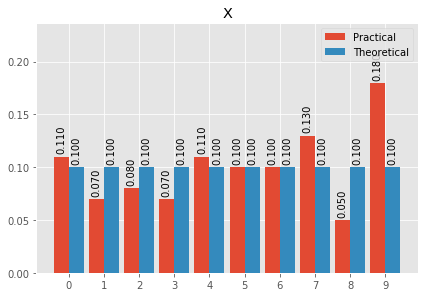

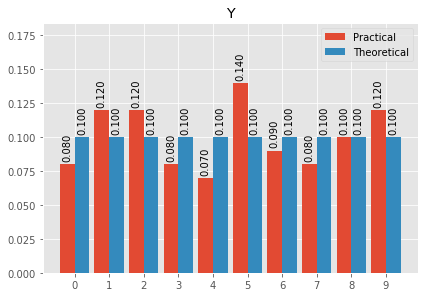

----------------------------------------
n = 1000


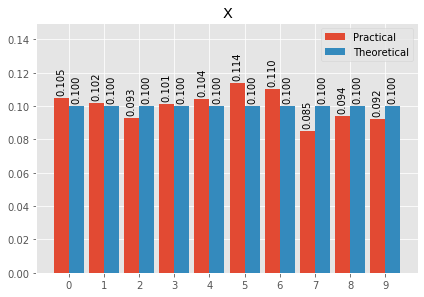

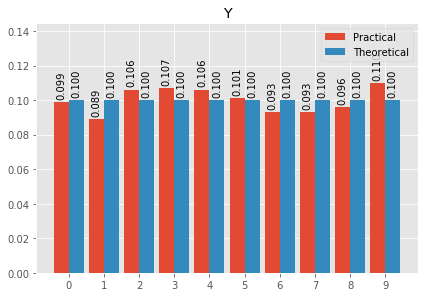

----------------------------------------
n = 10000


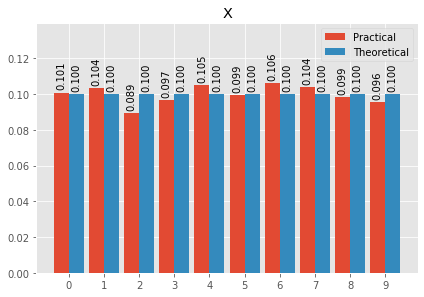

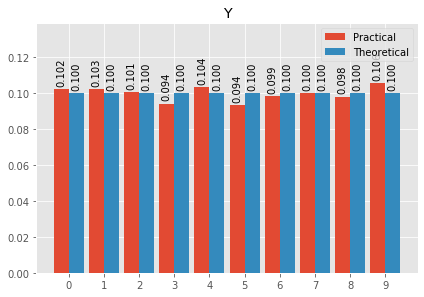

----------------------------------------
n = 100000


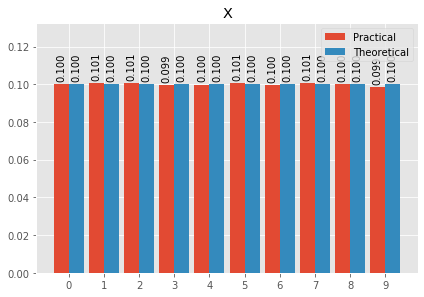

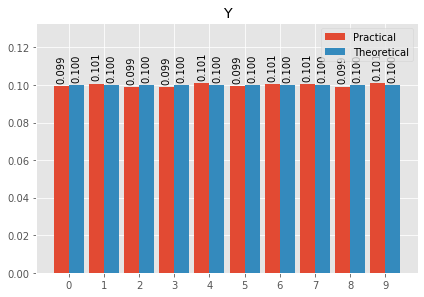

In [15]:
plot_distributions()

### Точечные оценки компонент

#### Матожидание

In [16]:
def expectation_table(mat, vals, axis=0):
    n, m = mat.shape
    
    res = 0
    for i in range(n):
        for j in range(m):
            val_id = j if axis else i
            res += mat[i, j] * vals[val_id]
    
    return res

In [17]:
@experiment(n, m, xvals, yvals)
def get_expectations(dis):
    m_xt = expectation_table(dis.theor, dis.xvals)
    m_yt = expectation_table(dis.theor, dis.yvals, 1)

    m_x = expectation_table(dis.emp, dis.xvals)
    m_y = expectation_table(dis.emp, dis.yvals, 1)
    
    print('Empirical E[X]: {:.6}, Theoretical E[X]: {:.6}'.format(m_x, m_xt))
    print('Empirical E[Y]: {:.6}, Theoretical E[Y]: {:.6}'.format(m_y, m_yt))

In [18]:
get_expectations()

----------------------------------------
n = 100
Empirical E[X]: 4.91, Theoretical E[X]: 4.5
Empirical E[Y]: 4.56, Theoretical E[Y]: 4.5
----------------------------------------
n = 1000
Empirical E[X]: 4.412, Theoretical E[X]: 4.5
Empirical E[Y]: 4.518, Theoretical E[Y]: 4.5
----------------------------------------
n = 10000
Empirical E[X]: 4.5069, Theoretical E[X]: 4.5
Empirical E[Y]: 4.5007, Theoretical E[Y]: 4.5
----------------------------------------
n = 100000
Empirical E[X]: 4.49025, Theoretical E[X]: 4.5
Empirical E[Y]: 4.50783, Theoretical E[Y]: 4.5


#### Дисперсия

In [19]:
def dispersion_table(mat, vals, axis=0):
    n, m = mat.shape
    e_x = expectation_table(mat, vals, axis)
    
    res = 0
    for i in range(n):
        for j in range(m):
            val_id = j if axis else i
            res += mat[i, j] * (vals[val_id] - e_x)**2
    
    return res

In [20]:
@experiment(n, m, xvals, yvals)
def get_dispersions(dis):
    d_xt = dispersion_table(dis.theor, dis.xvals)
    d_yt = dispersion_table(dis.theor, dis.yvals, 1)

    d_x = dispersion_table(dis.emp, dis.xvals)
    d_y = dispersion_table(dis.emp, dis.yvals, 1)
    
    print('Empirical D[X]: {:.6}, Theoretical D[X]: {:.6}'.format(d_x, d_xt))
    print('Empirical D[Y]: {:.6}, Theoretical D[Y]: {:.6}'.format(d_y, d_yt))

In [21]:
get_dispersions()

----------------------------------------
n = 100
Empirical D[X]: 8.9219, Theoretical D[X]: 8.25
Empirical D[Y]: 8.4264, Theoretical D[Y]: 8.25
----------------------------------------
n = 1000
Empirical D[X]: 8.02426, Theoretical D[X]: 8.25
Empirical D[Y]: 8.24368, Theoretical D[Y]: 8.25
----------------------------------------
n = 10000
Empirical D[X]: 8.17735, Theoretical D[X]: 8.25
Empirical D[Y]: 8.4142, Theoretical D[Y]: 8.25
----------------------------------------
n = 100000
Empirical D[X]: 8.2419, Theoretical D[X]: 8.25
Empirical D[Y]: 8.24876, Theoretical D[Y]: 8.25


#### Корелляция

In [22]:
def expectation_xy_table(mat, xvals, yvals):
    n, m = mat.shape

    res = 0
    for i in range(n):
        for j in range(m):
            res += mat[i, j] * xvals[i] * yvals[j]
    
    return res

In [23]:
@experiment(n, m, xvals, yvals)
def covariances(dis):
    m_x = expectation_table(dis.emp, dis.xvals)
    m_y = expectation_table(dis.emp, dis.xvals, 1)
    m_xy = expectation_xy_table(dis.emp, dis.xvals, dis.yvals)
    
    d_x = dispersion_table(dis.emp, dis.xvals)
    d_y = dispersion_table(dis.emp, dis.yvals, 1)

    covariance = m_xy - m_x * m_y
    r = covariance / (np.sqrt(d_x) * np.sqrt(d_y)) 
    
    print('r = {:.6}'.format(r))

In [24]:
covariances()

----------------------------------------
n = 100
r = 0.121145
----------------------------------------
n = 1000
r = 0.046179
----------------------------------------
n = 10000
r = -0.0101393
----------------------------------------
n = 100000
r = 0.00108138


### Доверительные интервалы

#### 1. Доверительный интервал для матожидания

In [25]:
from statlib.metrics import get_exp_interval

@experiment(n, m, xvals, yvals)
def build_exp_intervals(dis):
    for alpha_e in [0.01, 0.05, 0.1, 0.3]:
        laplace_e = (1 - alpha_e)

        m_x = expectation_table(dis.emp, dis.xvals)
        m_y = expectation_table(dis.emp, dis.xvals, 1)
        m_xy = expectation_xy_table(dis.emp, dis.xvals, dis.yvals)

        d_x = dispersion_table(dis.emp, dis.xvals)
        d_y = dispersion_table(dis.emp, dis.yvals, 1)

        interval_len_x = get_exp_interval(d_x, laplace_e, n * m)
        interval_len_y = get_exp_interval(d_y, laplace_e, n * m)

        print('Interval for E(X) with alpha = {} is ({}, {})'.format(alpha_e, m_x - interval_len_x, m_x + interval_len_x))
        print('Interval for E(Y) with alpha = {} is ({}, {})'.format(alpha_e, m_y - interval_len_y, m_y + interval_len_y))
        print('+++++++')

In [26]:
build_exp_intervals()

----------------------------------------
n = 100
Interval for E(X) with alpha = 0.01 is (2.834455690259501, 6.9855443097404955)
Interval for E(Y) with alpha = 0.01 is (2.5997262274182242, 6.520273772581773)
+++++++
Interval for E(X) with alpha = 0.05 is (3.4424780425701647, 6.377521957429832)
Interval for E(Y) with alpha = 0.05 is (3.1739805397856102, 5.946019460214387)
+++++++
Interval for E(X) with alpha = 0.1 is (3.7666125087367615, 6.053387491263235)
Interval for E(Y) with alpha = 0.1 is (3.4801133888094964, 5.6398866111905015)
+++++++
Interval for E(X) with alpha = 0.3 is (4.442135106567012, 5.377864893432985)
Interval for E(Y) with alpha = 0.3 is (4.118119151971696, 5.001880848028302)
+++++++
----------------------------------------
n = 1000
Interval for E(X) with alpha = 0.01 is (2.5452789113640546, 6.2787210886359475)
Interval for E(Y) with alpha = 0.01 is (2.6002341863118503, 6.4357658136881515)
+++++++
Interval for E(X) with alpha = 0.05 is (3.0921273414812895, 5.731872658518

#### 2. Доверительный интервал для дисперсии

In [27]:
from statlib.metrics import get_dispersion_borders

@experiment(n, m, xvals, yvals)
def build_dispersion_intervals(dis):
    for alpha_e in [0.01, 0.05, 0.1, 0.3]:
        laplace_e = (1 - alpha_e)
        
        d_x = dispersion_table(dis.emp, dis.xvals)
        d_y = dispersion_table(dis.emp, dis.yvals, 1)

        dx_l, dx_r = get_dispersion_borders(d_x, laplace_e, dis.total)
        dy_l, dy_r = get_dispersion_borders(d_y, laplace_e, dis.total)

        print('Interval for D(X) with alpha = {} is ({}, {})'.format(alpha_e, dx_l, dx_r))
        print('Interval for D(Y) with alpha = {} is ({}, {})'.format(alpha_e, dy_l, dy_r))
        print('+++++++')

In [28]:
build_dispersion_intervals()

----------------------------------------
n = 100
Interval for D(X) with alpha = 0.01 is (8.966286742872272, 8.99837949814024)
Interval for D(Y) with alpha = 0.01 is (8.468321614245724, 8.498632018194435)
+++++++
Interval for D(X) with alpha = 0.05 is (8.902507655031918, 9.06307683845005)
Interval for D(Y) with alpha = 0.05 is (8.408084657344396, 8.559736230120883)
+++++++
Interval for D(X) with alpha = 0.1 is (8.823334204652891, 9.145135044401776)
Interval for D(Y) with alpha = 0.1 is (8.33330830227722, 8.637237128655011)
+++++++
Interval for D(X) with alpha = 0.3 is (8.506529310173477, 9.494240410094045)
Interval for D(Y) with alpha = 0.3 is (8.034097958870397, 8.966954055931637)
+++++++
----------------------------------------
n = 1000
Interval for D(X) with alpha = 0.01 is (8.025111268281352, 8.034119696723078)
Interval for D(Y) with alpha = 0.01 is (8.24455465524287, 8.253809415477686)
+++++++
Interval for D(X) with alpha = 0.05 is (8.007120657697623, 8.052191263562024)
Interval fo

### Критерий хи-квадрат

In [29]:
def calc_chi(theor, emp):
    n, m = emp.shape
    
    chi_val = 0
    for i in range(n):
        for j in range(m):
            chi_val += (theor[i, j] - emp[i, j])**2 / theor[i, j]
    
    return chi_val * n * m

def chi2_1d(theor_probs, emp_probs):
    n = len(theor_probs)
    
    chi_val = 0
    for i in range(n):
        chi_val += (theor_probs[i] - emp_probs[i])**2 / theor_probs[i]
    
    return chi_val / n

In [30]:
from scipy.stats import chi2

@experiment(n, m, xvals, yvals)
def build_chi_criteria(dis):
    alpha = 0.05
    
    emp_chi = calc_chi(dis.theor, dis.emp)
    theor_chi = chi2.ppf(alpha, dis.total_vars)
    
    x_chi = chi2_1d(dis.x_prob_t, dis.x_emp)
    y_chi = chi2_1d(dis.y_prob_t, dis.y_emp)
    
    print('alpha = {}')
    print('practical = {:.6}, theoretical = {:.6}'.format(alpha, emp_chi, theor_chi))
    print('x practical = {:.6}'.format(x_chi))
    print('y practical = {:.6}'.format(y_chi))

In [31]:
build_chi_criteria()

----------------------------------------
n = 100
alpha = {}
practical = 0.05, theoretical = 86.0
x practical = 0.0122
y practical = 0.005
----------------------------------------
n = 1000
alpha = {}
practical = 0.05, theoretical = 10.16
x practical = 0.000716
y practical = 0.000458
----------------------------------------
n = 10000
alpha = {}
practical = 0.05, theoretical = 1.0554
x practical = 0.0002359
y practical = 0.0001397
----------------------------------------
n = 100000
alpha = {}
practical = 0.05, theoretical = 0.097288
x practical = 4.2598e-06
y practical = 7.1368e-06
